# Gravitational Lens Classification with CNN

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from torch.utils.data import DataLoader, Dataset, random_split
import seaborn as sns


In [11]:
# Global Parameters

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# Model saving
SAVE_MODEL = True
MODEL_SAVE_PATH = '../models/lens_cnn.pth'

# Dataset paths
TRAIN_LENSES_PATH = '../dataset/train_lenses/'
TRAIN_NONLENSES_PATH = '../dataset/train_nonlenses/'
TEST_LENSES_PATH = '../dataset/test_lenses/'
TEST_NONLENSES_PATH = '../dataset/test_nonlenses/'

Using device: cuda:0


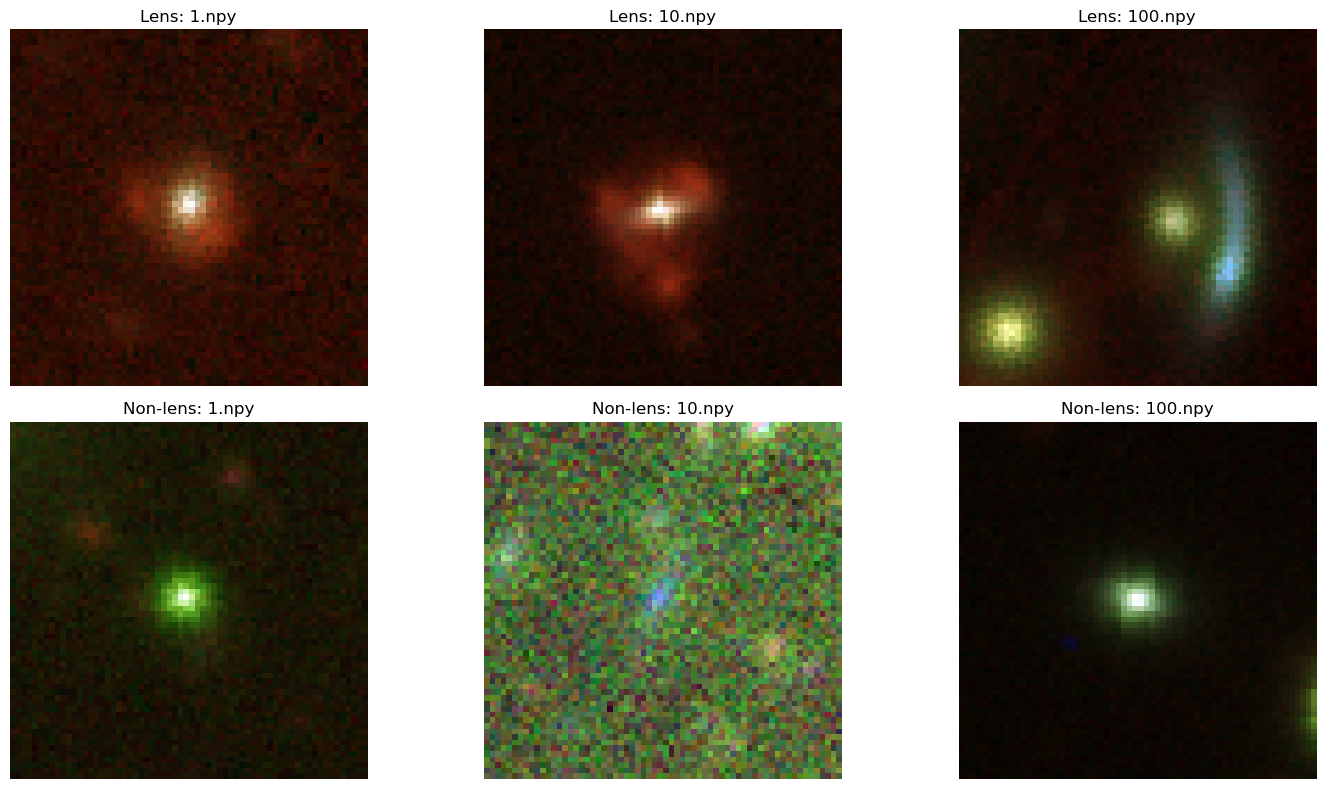

In [12]:
# ## Visualize Sample Images

def visualize_sample_images(lenses_dir, nonlenses_dir, num_samples=3):
    """Plot sample images from both classes"""
    lens_files = os.listdir(lenses_dir)[:num_samples]
    nonlens_files = os.listdir(nonlenses_dir)[:num_samples]
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    for i, file_name in enumerate(lens_files):
        img = np.load(os.path.join(lenses_dir, file_name))
        
        # Normalize for display
        img = np.transpose(img, (1, 2, 0))  # Convert from (3, 64, 64) to (64, 64, 3)
        img = (img - img.min()) / (img.max() - img.min())
        
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Lens: {file_name}")
        axes[0, i].axis('off')
    
    for i, file_name in enumerate(nonlens_files):
        img = np.load(os.path.join(nonlenses_dir, file_name))
        
        # Normalize for display
        img = np.transpose(img, (1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())
        
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Non-lens: {file_name}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('../results/sample_images.png')
    plt.show()

# Visualize training samples
visualize_sample_images(TRAIN_LENSES_PATH, TRAIN_NONLENSES_PATH)

In [13]:
# Custom Dataset

class LensClassificationDataset(Dataset):
    def __init__(self, lenses_dir, nonlenses_dir):
        self.lenses_dir = lenses_dir
        self.nonlenses_dir = nonlenses_dir
        
        # Get file paths
        self.lenses_files = [os.path.join(lenses_dir, f) for f in os.listdir(lenses_dir)]
        self.nonlenses_files = [os.path.join(nonlenses_dir, f) for f in os.listdir(nonlenses_dir)]
        
        self.files = self.lenses_files + self.nonlenses_files
        self.labels = [1] * len(self.lenses_files) + [0] * len(self.nonlenses_files)
        
        # Print class distribution
        print(f"Lenses: {len(self.lenses_files)}, Non-lenses: {len(self.nonlenses_files)}")
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path = self.files[idx]
        data = np.load(file_path)  # Load .npy file with shape (3, 64, 64)
        
        # Normalize the data
        data = (data - np.mean(data)) / (np.std(data) + 1e-8)
        
        # Convert to tensor
        tensor_data = torch.tensor(data, dtype=torch.float32)
        label = self.labels[idx]
        
        return tensor_data, label


In [14]:
# Data Loading and Preparation

# Create datasets
train_dataset = LensClassificationDataset(TRAIN_LENSES_PATH, TRAIN_NONLENSES_PATH)
test_dataset = LensClassificationDataset(TEST_LENSES_PATH, TEST_NONLENSES_PATH)

# Data splits
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(test_dataset)}")

Lenses: 1730, Non-lenses: 28675
Lenses: 195, Non-lenses: 19455
Training samples: 24324
Validation samples: 6081
Test samples: 19650


In [15]:
# Model Architecture
class LensCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(LensCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(dropout_rate)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second block
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third block
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten and fully connected layers
        x = x.view(-1, 128 * 8 * 8)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

In [16]:
# Initialize Model and Optimizer

# Calculate class weights to handle imbalance
num_lenses = len(train_dataset.lenses_files)
num_nonlenses = len(train_dataset.nonlenses_files)
total = num_lenses + num_nonlenses
class_weights = torch.tensor([total / (2 * num_nonlenses), total / (2 * num_lenses)], dtype=torch.float32)
class_weights = class_weights.to(device)

model = LensCNN().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [17]:
# Training Function

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

In [18]:
# Validation Function

def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total
    
    return val_loss, val_acc


In [19]:
# Training Loop

def train_model():
    # For tracking metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    
    for epoch in range(EPOCHS):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Print stats
        print(f"Epoch [{epoch+1}/{EPOCHS}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_loss < best_val_loss and SAVE_MODEL:
            best_val_loss = val_loss
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Model saved at epoch {epoch+1}")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('../results/training_history.png')
    plt.show()
    
    return train_losses, train_accuracies, val_losses, val_accuracies


Epoch [1/20] | Train Loss: 0.6750 | Train Acc: 77.93% | Val Loss: 0.5244 | Val Acc: 66.81%
Model saved at epoch 1
Epoch [2/20] | Train Loss: 0.5572 | Train Acc: 75.15% | Val Loss: 0.4562 | Val Acc: 76.35%
Model saved at epoch 2
Epoch [3/20] | Train Loss: 0.5311 | Train Acc: 77.43% | Val Loss: 0.4265 | Val Acc: 78.06%
Model saved at epoch 3
Epoch [4/20] | Train Loss: 0.4890 | Train Acc: 79.98% | Val Loss: 0.3853 | Val Acc: 79.67%
Model saved at epoch 4
Epoch [5/20] | Train Loss: 0.4603 | Train Acc: 80.05% | Val Loss: 0.4087 | Val Acc: 78.33%
Epoch [6/20] | Train Loss: 0.4725 | Train Acc: 79.83% | Val Loss: 0.4225 | Val Acc: 76.16%
Epoch [7/20] | Train Loss: 0.4243 | Train Acc: 82.46% | Val Loss: 0.3496 | Val Acc: 81.43%
Model saved at epoch 7
Epoch [8/20] | Train Loss: 0.4541 | Train Acc: 83.17% | Val Loss: 0.3249 | Val Acc: 88.03%
Model saved at epoch 8
Epoch [9/20] | Train Loss: 0.4167 | Train Acc: 83.93% | Val Loss: 0.3374 | Val Acc: 86.37%
Epoch [10/20] | Train Loss: 0.3933 | Train 

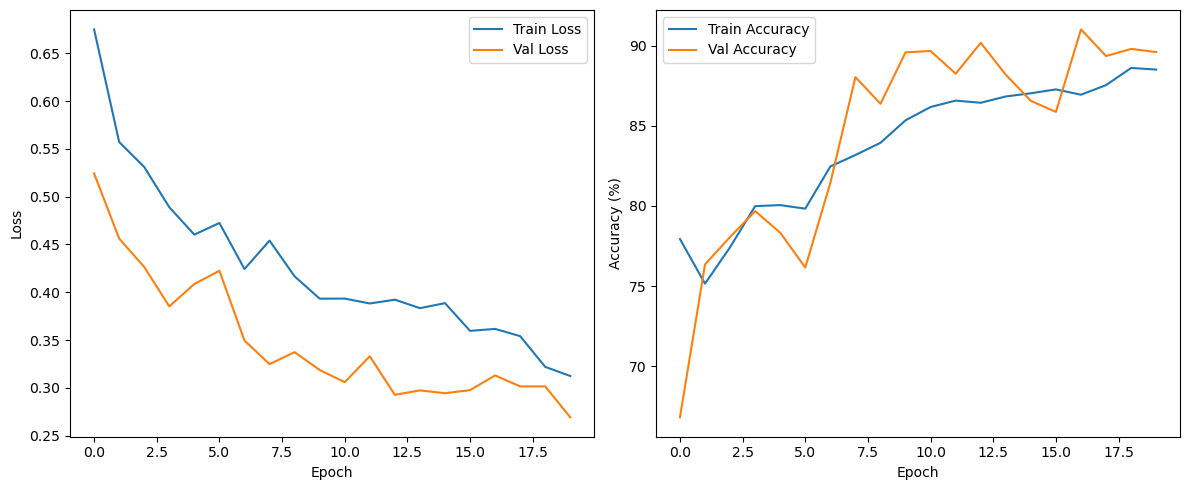

In [20]:
# Run Training
history = train_model()

In [21]:
# Evaluation Functions

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilities for the positive class
    
    # Calculate metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('../results/confusion_matrix.png')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig('../results/roc_curve.png')
    plt.show()
    
    return roc_auc


Loaded best model for evaluation
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.94     19455
           1       0.08      0.86      0.14       195

    accuracy                           0.90     19650
   macro avg       0.54      0.88      0.54     19650
weighted avg       0.99      0.90      0.94     19650



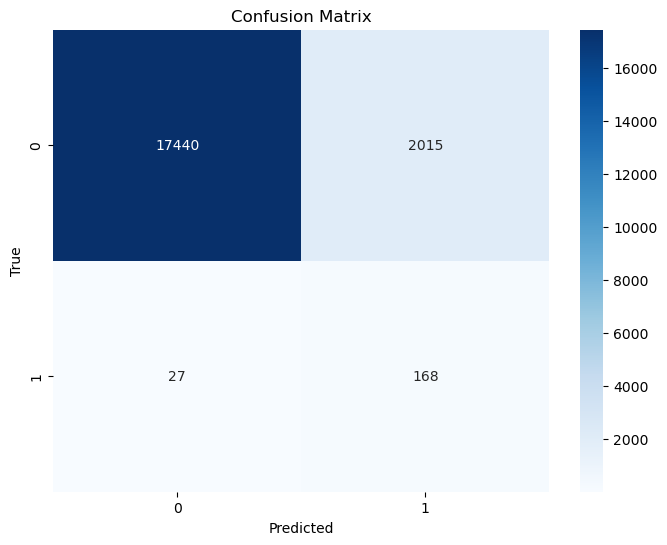

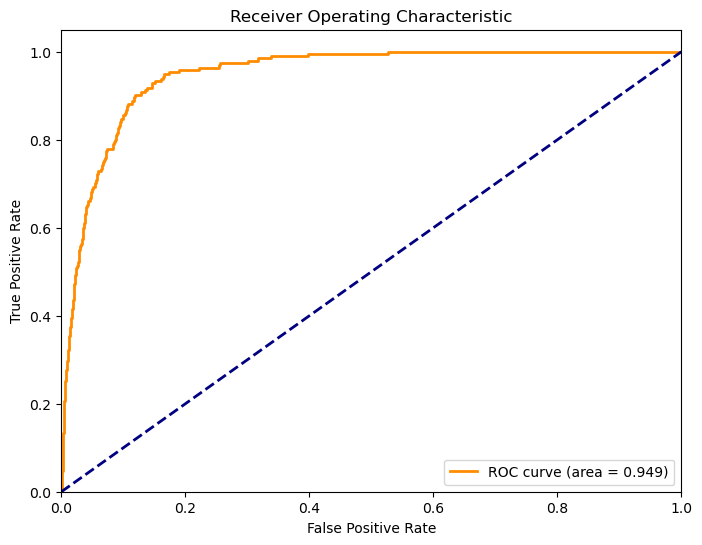

Final AUC Score: 0.9488


In [22]:
# Evaluate Model

# Load best model if available
if os.path.exists(MODEL_SAVE_PATH):
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    print("Loaded best model for evaluation")

roc_auc_score = evaluate_model(model, test_loader)
print(f"Final AUC Score: {roc_auc_score:.4f}")

In [23]:
# Visualize Sample Predictions

def visualize_predictions(model, test_loader, num_samples=5):
    model.eval()
    
    # Get some test samples
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Make predictions
    images = images[:num_samples].to(device)
    labels = labels[:num_samples].cpu().numpy()
    
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    # Convert to numpy for visualization
    images = images.cpu().numpy()
    predicted = predicted.cpu().numpy()
    probs = probs.cpu().numpy()
    
    # Plot images with predictions
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    for i in range(num_samples):
        # Display the RGB image
        # Take the first 3 channels and transpose to (64, 64, 3) for matplotlib
        img = np.transpose(images[i], (1, 2, 0))
        
        # Normalize to [0, 1] for display
        img = (img - img.min()) / (img.max() - img.min())
        
        axes[i].imshow(img)
        axes[i].set_title(f"True: {'Lens' if labels[i] == 1 else 'Non-lens'}\n"
                         f"Pred: {'Lens' if predicted[i] == 1 else 'Non-lens'}\n"
                         f"Prob: {probs[i][1]:.2f}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('../results/sample_predictions.png')
    plt.show()

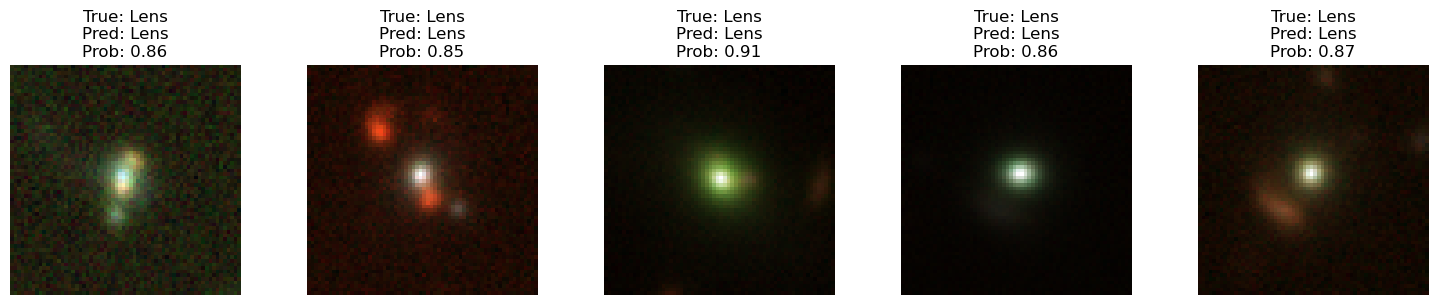

In [24]:
# Visualize Sample Predictions

visualize_predictions(model, test_loader)